# Big data made small

Follow along the notebook to learn how to use SQL through [DuckDB](https://duckdb.org/), a **fast** database system, available through both python and R.

In [1]:
# Import today's main character
import duckdb

## Basic building blocks of SQL querying

SQL is a declarative language that allows you to query tables from databases. There's plenty of database ecosystems out there. If you work with data in a large organization, you'll encounter at least one. Often more.

DuckDB is an **analytical** database system that allows extreme flexibility in querying data in different formats. Today we will focus primarily on `parquet` files (though you could also directly work on e.g. `CSV`s).

[`parquet`](https://parquet.apache.org/) is a data format optimized for efficient data retrieval. There's more and more data available as parquet files out there, and there's multiple way to transform your data into parquet - the easiest probably being [exporting from pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_parquet.html). 

For today, we'll assume you got the data in this format, which will be created in your local `./data/` folder as soon as you run `uv run create_data.py`.

This introduction runs through the basic syntax of `SELECT` statements in SQL. These constitutes the vast majority of SQL work for an analytist.

### SELECT FROM + LIMIT

`SELECT` statements are structured as follows

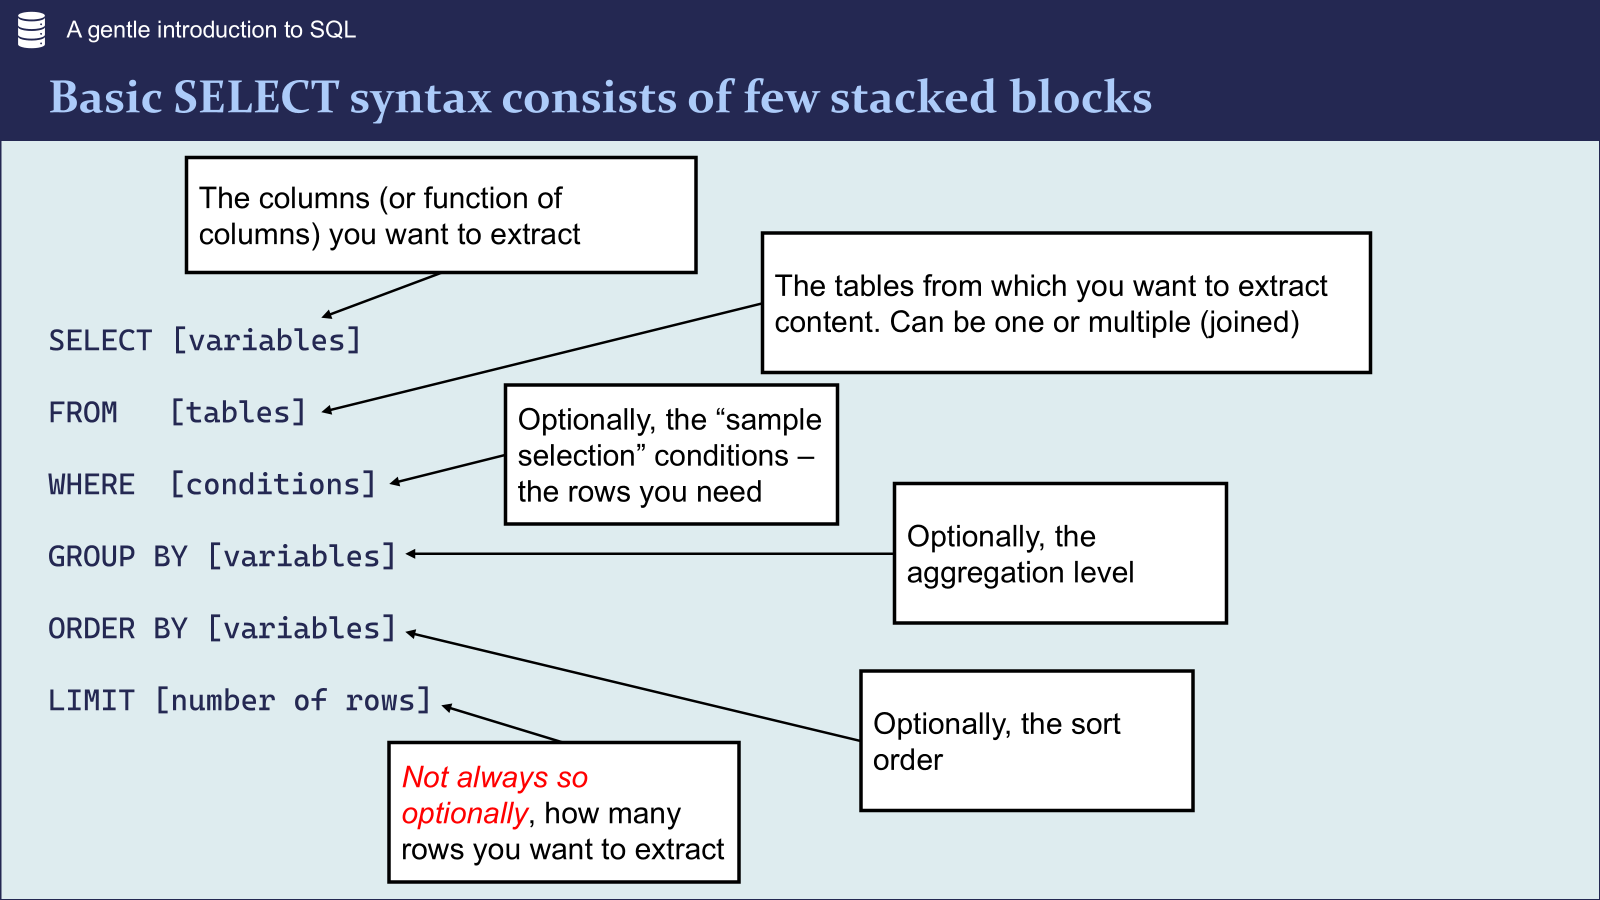

A basic query could then look something like

```SQL
SELECT
    column1, column2
FROM thistable
LIMIT 5
```

This query means "Extract the first 5 records of columns `column1` and `column2` from table `thistable`. You could also usethe character `*` as jolly to return all columns in a table.

> **WARNING**
> 
> If you are doing exploratory analysis "just to look at the data", **always** impose a `LIMIT` condition to ensure you don't load everything in the memory. DuckDB (and database engines in general) can handle larger-than-RAM datasets. Loading a huge table  up is a safe recipe for crashing your computer sooner or later.

DuckDB allows to run SQL queries **directly on your `parquet` files**! This means you will not load the whole dataset in memory. DuckDb will intelligently scan the data, select only the tidbits you need, alaborate them, and return them.

So say we want to "look at what's in `../data/tests.parquet` file. We can adapt the basic query above to  

```SQL
select te.*
from read_parquet('../data/tests.parquet') as te
limit 5
```

Where `read_parquet()` is a DuckDb function reading parquet files.

> **NOTE**
>
> Strings in SQL always are delimited by character `'`, **not** `"`


With DuckDB, we can run SQL query simply by encapsulating them into `duckdb.sql()` as follows 

In [2]:
%%time
duckdb.sql(
    """
    select te.*
    from read_parquet('../data/tests.parquet') as te
    limit 5
    """
)

CPU times: user 3.97 ms, sys: 387 µs, total: 4.36 ms
Wall time: 10.8 ms


┌─────────────────────┬─────────┬──────────┐
│      test_time      │   id    │ positive │
│    timestamp_ns     │  int64  │  int64   │
├─────────────────────┼─────────┼──────────┤
│ 2022-02-11 00:28:50 │ 2004206 │        0 │
│ 2022-03-20 10:41:34 │  113107 │        1 │
│ 2022-08-17 03:59:32 │  979034 │        0 │
│ 2022-09-08 06:24:04 │ 2765675 │        0 │
│ 2022-12-13 19:01:15 │ 2070417 │        0 │
└─────────────────────┴─────────┴──────────┘

Easy! Looked at the data in a tiny fraction of a second, without the need of loading all the dataset in the memory.

`duckdb.sql()` returns a relation object. You can convert it in other formats, like a `pandas.DataFrame`, e.g.

In [3]:
%%time
df = duckdb.sql(
    """
    select te.*
    from read_parquet('../data/tests.parquet') as te
    limit 5
    """
).df()

df

CPU times: user 725 ms, sys: 559 ms, total: 1.28 s
Wall time: 957 ms


,test_time,id,positive
0,2022-02-11 00:28:50,2004206,0
1,2022-03-20 10:41:34,113107,1
2,2022-08-17 03:59:32,979034,0
3,2022-09-08 06:24:04,2765675,0
4,2022-12-13 19:01:15,2070417,0


### WHERE and ORDER BY

We can add a condition to the query. For example, we can get all tests done by `id=5` after August 2022 by using a `WHERE` statement.

Note that now I am not using a `LIMIT` condition anymore, as I know the data output will be limited in this case.

I am also using `ORDER BY` at the end to order rows chronologically.

In [4]:
%%time
duckdb.sql(
    """
    select te.*
    from read_parquet('../data/tests.parquet') as te
    where te.id=5
        and cast(te.test_time as date)>='2022-08-01'
    ORDER BY te.test_time
    """
)

CPU times: user 0 ns, sys: 3.5 ms, total: 3.5 ms
Wall time: 2.13 ms


┌─────────────────────┬───────┬──────────┐
│      test_time      │  id   │ positive │
│    timestamp_ns     │ int64 │  int64   │
├─────────────────────┼───────┼──────────┤
│ 2022-08-13 01:20:47 │     5 │        0 │
│ 2022-08-31 09:26:49 │     5 │        0 │
│ 2022-09-10 07:38:21 │     5 │        0 │
│ 2022-11-12 11:50:07 │     5 │        0 │
└─────────────────────┴───────┴──────────┘

### GROUP BY

`GROUP BY` serves to aggregate our data. Via SQL, you can aggregate the data *without* loading all rows in a pandas dataframe. For example, say we want to count how many tests have been done by month in the `tests` data, and the percentage of them showing up positive (here data is simulated, so no useful pattern will show up).

In [5]:
%%time
duckdb.sql(
    """
    select
        month(test_time) as month
        , COUNT(*) as n_tests
        , MEAN(positive) as share_positive
    from read_parquet('../data/tests.parquet') as te
    GROUP BY month(test_time)
    ORDER BY month(test_time)
    """
)

CPU times: user 1.46 ms, sys: 691 µs, total: 2.15 ms
Wall time: 1.33 ms


┌───────┬─────────┬─────────────────────┐
│ month │ n_tests │   share_positive    │
│ int64 │  int64  │       double        │
├───────┼─────────┼─────────────────────┤
│     1 │ 3834859 │ 0.07970618997986627 │
│     2 │ 3459620 │ 0.07996514068019031 │
│     3 │ 3829567 │ 0.07966592567775939 │
│     4 │ 3710265 │ 0.07995116251804116 │
│     5 │ 3835185 │ 0.07991817865370249 │
│     6 │ 3705759 │ 0.08002328267974253 │
│     7 │ 3833010 │ 0.07986386677832825 │
│     8 │ 3830474 │ 0.08007520740253034 │
│     9 │ 3708918 │ 0.07996024716642428 │
│    10 │ 3835433 │  0.0799581168540814 │
│    11 │ 3708389 │ 0.07998702401501029 │
│    12 │ 3708521 │ 0.08023252396305697 │
├───────┴─────────┴─────────────────────┤
│ 12 rows                     3 columns │
└───────────────────────────────────────┘

## Expanding `FROM`

### Subqueries and Common Table Expressions (CTEs)

Let's go back to `FROM`. The easiest way of `FROM` takes as input a single table. But a table can also be the result of a query itself!

For example, let's see how the distribution of many times each person in the dataset was tested. To do so, we need to

1. calculate the number of tests per id in the data
2. sum how many ID occurrences per number of tests. 

Or:

In [6]:
%%time
duckdb.sql(
    """
    SELECT n_tests, count(id) as n_ppl 
    FROM (
        SELECT id, count(id) as n_tests 
        from read_parquet('../data/tests.parquet') 
        GROUP BY id
    ) as t
    GROUP BY n_tests
    ORDER BY n_tests
    """
)

CPU times: user 1.25 ms, sys: 510 µs, total: 1.76 ms
Wall time: 1.38 ms


┌─────────┬────────┐
│ n_tests │ n_ppl  │
│  int64  │ int64  │
├─────────┼────────┤
│       1 │     12 │
│       2 │    101 │
│       3 │    515 │
│       4 │   1927 │
│       5 │   5826 │
│       6 │  14424 │
│       7 │  30894 │
│       8 │  57953 │
│       9 │  97722 │
│      10 │ 145706 │
│       · │     ·  │
│       · │     ·  │
│       · │     ·  │
│      29 │   1240 │
│      30 │    680 │
│      31 │    359 │
│      32 │    136 │
│      33 │     57 │
│      34 │     25 │
│      35 │     11 │
│      36 │      3 │
│      37 │      1 │
│      39 │      1 │
├─────────┴────────┤
│     38 rows      │
│    (20 shown)    │
└──────────────────┘

That's a subquery. Problem with subqueries is that with subqueries, even with copious indentation, queries quickly become hard to read.

Enter **Common Table Expressions (CTEs)** - almost the same, but the query gets much more legible. Another advantage is that we'd be able to reuse table `t`multiple times in the following code, if needed, without rewriting all the subquery.

In [7]:
%%time
duckdb.sql(
    """
    WITH t as (
        SELECT id, count(id) as n_tests 
        from read_parquet('../data/tests.parquet') 
        GROUP BY id
    )
    SELECT n_tests, count(id) as n_ppl 
    FROM t
    GROUP BY n_tests
    ORDER BY n_tests
    """
)

CPU times: user 2.2 ms, sys: 329 µs, total: 2.52 ms
Wall time: 1.37 ms


┌─────────┬────────┐
│ n_tests │ n_ppl  │
│  int64  │ int64  │
├─────────┼────────┤
│       1 │     12 │
│       2 │    101 │
│       3 │    515 │
│       4 │   1927 │
│       5 │   5826 │
│       6 │  14424 │
│       7 │  30894 │
│       8 │  57953 │
│       9 │  97722 │
│      10 │ 145706 │
│       · │     ·  │
│       · │     ·  │
│       · │     ·  │
│      29 │   1240 │
│      30 │    680 │
│      31 │    359 │
│      32 │    136 │
│      33 │     57 │
│      34 │     25 │
│      35 │     11 │
│      36 │      3 │
│      37 │      1 │
│      39 │      1 │
├─────────┴────────┤
│     38 rows      │
│    (20 shown)    │
└──────────────────┘

### The real deal: JOINs

As mentioned in the slides, working with relational databases means joining lots of table together. That's SQL real superpower.

`JOIN` is how we combine multiple tables. Essentially that'd be `pd.DataFrame.merge()` - just exceptionally more powerful. The table below summarizes the key differences, and I will explain them briefly at the workshop, but as analysts you'd most often deal with two of these: `INNER JOIN` and `LEFT JOIN`.

![image](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.techagilist.com%2Fwp-content%2Fuploads%2F2018%2F07%2Fsql-joins.png&f=1&nofb=1&ipt=187475e01030755dedb9dcd23da61bdb8650b747c4fca8004eb442d243191213&ipo=images)

The idea is simply to take all rows from a table, and attach all rows from a second table according to a (set of) column(s). So for example I want to join each id from Table A to each ID of Table B.

* `INNER JOIN`: Returns *only rows where IDs are found in **both** tables*
* `LEFT JOIN`: Returns *all rows from table A*, joining data from Table B when available (the rest being `NULL`)

In the simulated data, for example, let's say that the `tests` data contains tests for all the population, while the `transactions` data only contains transaction of clients of a specific financial institute. Indeed, we could count how many `DISTINCT` IDs we have in both tables.

In [8]:
%%time
print(
    duckdb.sql(
        """select count(distinct id) as id_tests
        from read_parquet('../data/tests.parquet')
        """
    )
)
print(
    duckdb.sql(
        """
        select count(distinct id) as id_transactions
        from read_parquet('../data/transactions.parquet')
        """
    )
)

┌──────────┐
│ id_tests │
│  int64   │
├──────────┤
│  2999999 │
└──────────┘

┌─────────────────┐
│ id_transactions │
│      int64      │
├─────────────────┤
│          899999 │
└─────────────────┘

CPU times: user 23.9 s, sys: 1.6 s, total: 25.5 s
Wall time: 3.45 s


Let's say we want to create a dataframe with as columns:
- The ID of the person (key)
- Whether a pwerson ever tasted positive
- The number of transactions the person made

So first we aggregate the tests and transaction table, and then join them. Let's start with a `LEFT JOIN`, where the `LEFT` table is the aggregated test table.

We get out 2999999 rows (the number of unique IDs in the `tests` table), but many of them have a missing `n_transactions`. We do not have transaction data for those individuals. However, we still retain the full sample, as we do have test data for the full population.

In [9]:
%%time
duckdb.sql(
    """
    with te as (
        SELECT id, max(positive) as ever_positive
        FROM read_parquet('../data/tests.parquet')
        GROUP BY id
    ), tr as (
        SELECT id, count(id) as n_transactions
        FROM read_parquet('../data/transactions.parquet')
        GROUP BY id
    )
    SELECT
        te.*, tr.n_transactions
    FROM te
    LEFT JOIN tr
        ON te.id=tr.id
    ORDER BY te.id DESC
    """
).df()

CPU times: user 36.8 s, sys: 1.15 s, total: 38 s
Wall time: 3.64 s


,id,ever_positive,n_transactions
0,2999999,1,NaN
1,2999998,1,NaN
2,2999997,1,NaN
3,2999996,1,NaN
4,2999995,1,NaN
...,...,...,...
2999994,5,0,121.0
2999995,4,1,113.0
2999996,3,1,113.0
2999997,2,1,92.0


Were we to do an `INNER JOIN` instead, we'd get 899999 rows - the clients having *both* test and transaction data.

In [10]:
%%time
duckdb.sql(
    """
    with te as (
        SELECT id, max(positive) as ever_positive
        FROM read_parquet('../data/tests.parquet')
        GROUP BY id
    ), tr as (
        SELECT id, count(id) as n_transactions
        FROM read_parquet('../data/transactions.parquet')
        GROUP BY id
    )
    SELECT
        count(*)
    FROM te
    INNER JOIN tr
        ON te.id=tr.id
    """
)

CPU times: user 4.41 ms, sys: 0 ns, total: 4.41 ms
Wall time: 2.29 ms


┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       899999 │
└──────────────┘

### Non-trivial JOINs

The joins we have seen above are quite straightfoward: One key, with equality. These joins are also straighforward with e.g. pandas. However, SQL allows you to handle much more complex joins.

For example, joins on 
- Multiple keys (e.g. id and date)
- Function of keys (e.g. month of a date)
- Unequal joins (e.g. on X>Y)

To try it out, let's try to find out all transactions made by people who tested positive 2 to 5 days before the positive test: That is, when they were asymptomatic but likely contagious.

Now, this starts to be a somewhat complex operation. We need to:

* Extract all positive tests. That's 3.597.337 positive tests in the simulated data.
* Find all transactions made by the individual being tested. The number of rows would grow to 108.989.386 transactions.
* Only select those where the time range fits.

The code belows does this join in `pandas`. It's uncommented, as you should only try it out if you have ~10GB RAM memory to spare. It takes about 35 seconds to run on my machine.

> **Note:** There'll be a few records not matching due to how pandas and sql engines treat date boundaries.

In [11]:
# %%time
# import pandas as pd
# tests = pd.read_parquet('../data/tests.parquet')
# transactions = pd.read_parquet('../data/transactions.parquet')

# pt = tests.loc[tests["positive"]==1]
# tt = pt.merge(transactions, on='id', how='inner')
# tt["infector_days_to_test"] = (tt["transaction_time"] - tt["test_time"]).dt.days + 1
# tt = tt[tt["infector_days_to_test"].between(-5, -2)]
# tt

The same query in in DuckDB runs in ~3 seconds on my machine, and the RAM is not nearly as challenged.

In [12]:
%%time
experiments = duckdb.sql(
    """
    select t.id as infector_id, t.test_time as infector_test_time
        , tt.transaction_time as infector_transaction_time, tt.shop
        , date_sub('days', t.test_time, tt.transaction_time) as infector_days_to_test
        --, row_number() over() as experiment_number
    from read_parquet('../data/tests.parquet') as t
    inner join read_parquet('../data/transactions.parquet') as tt
        on tt.id=t.id 
        and date_sub('days', t.test_time, tt.transaction_time) between -5 and -2
    where t.positive=1
    --order by t.id, infector_test_date, infector_transaction_time
    """
).df()
experiments

CPU times: user 35.2 s, sys: 1.42 s, total: 36.6 s
Wall time: 3.89 s


,infector_id,infector_test_time,infector_transaction_time,shop,infector_days_to_test
0,748634,2022-01-30 16:44:20,2022-01-25 01:45:40,29267,-5
1,356098,2022-02-13 05:39:20,2022-02-09 07:56:44,37661,-3
2,706157,2022-10-06 11:46:09,2022-10-02 11:40:20,39292,-4
3,600000,2022-02-27 19:08:48,2022-02-24 12:34:47,32702,-3
4,698513,2022-11-24 22:38:27,2022-11-21 07:58:40,45576,-3
...,...,...,...,...,...
1184794,291930,2022-09-27 04:41:26,2022-09-21 11:14:59,29588,-5
1184795,674914,2022-04-08 15:22:07,2022-04-04 17:30:34,27595,-3
1184796,142380,2022-11-05 02:43:09,2022-11-01 21:18:17,14394,-3
1184797,372243,2022-11-03 14:01:43,2022-10-31 17:58:21,46593,-2


## All together: Find all transactions by people crossing an infector in a store!

Now the final step. Let's take the *experiments* we identified in the previous query, and join them with all transactions by other people happening in the same store within 30 minutes of the original transactions. Piece of cake!

>The way I'd approach building the query:
>1) Get the basic ingredeints there. We have a query creating our "experiments". Start from that.
>2) Understand which data I need additionally - here the `transactions` data.
>3) Write down the conditions under which combinations of transactions are acceptable. For example, they need to be
>    * In the same shop
>    * Not by the same person (the "*infector*")
>    * Within a specific time range
>4) Potentially construct additional variables (here "treatment")

In [13]:
%%time
duckdb.sql(
    """
    with experiments as (
        select t.id as infector_id, t.test_time as infector_test_time
            , tt.transaction_time as infector_transaction_time, tt.shop
            , date_sub('days', t.test_time, tt.transaction_time) as infector_days_to_test
            , row_number() over() as experiment_number
        from read_parquet('../data/tests.parquet') as t
        inner join read_parquet('../data/transactions.parquet') as tt
            on tt.id=t.id 
            and date_sub('days', t.test_time, tt.transaction_time) between -5 and -2
        where t.positive=1
        -- a small number to test it out
        limit 1000
    ) 
    select e.*
    , t2.id as exposed_id, t2.transaction_time as exposed_transaction_time
    , date_sub('minutes', t2.transaction_time, e.infector_transaction_time) as minutes_apart
    , case when date_sub('minutes', t2.transaction_time, e.infector_transaction_time) between -5 and +5 then 1 
        when date_sub('minutes', t2.transaction_time, e.infector_transaction_time) between -30 and -16 then 0
        else NULL end as treat
    from experiments as e
    inner join read_parquet('../data/transactions.parquet') as t2
        -- in the same shop
        on t2.shop=e.shop
        -- I do not want the infector transactions there!
        and t2.id!=e.infector_id
        --order by experiment_number, exposed_transaction_time
        and t2.transaction_time between
            e.infector_transaction_time - interval 30 minutes
            and e.infector_transaction_time + interval 30 minutes
    """
).df()

CPU times: user 10.1 s, sys: 519 ms, total: 10.6 s
Wall time: 1.01 s


,infector_id,infector_test_time,infector_transaction_time,shop,infector_days_to_test,experiment_number,exposed_id,exposed_transaction_time,minutes_apart,treat
0,254121,2022-11-26 10:01:03,2022-11-22 13:53:53,14101,-3,155,716569,2022-11-22 14:20:56,-27,0.0
1,772176,2022-02-13 08:38:44,2022-02-08 07:32:14,2393,-5,48,841204,2022-02-08 07:18:32,13,NaN
2,803515,2022-11-28 00:19:43,2022-11-25 04:54:15,31622,-2,586,599542,2022-11-25 05:03:21,-9,NaN
3,476750,2022-05-21 02:15:00,2022-05-16 01:48:22,5916,-5,884,797794,2022-05-16 02:15:13,-26,0.0
4,707430,2022-09-19 02:06:09,2022-09-14 09:07:10,11455,-4,483,376808,2022-09-14 09:10:11,-3,1.0
...,...,...,...,...,...,...,...,...,...,...
234,863731,2022-04-04 12:03:57,2022-04-01 05:29:46,31105,-3,977,864781,2022-04-01 05:59:17,-29,0.0
235,73403,2022-04-06 20:13:09,2022-04-03 04:21:20,9184,-3,524,289682,2022-04-03 04:43:51,-22,0.0
236,824790,2022-07-22 06:12:06,2022-07-18 19:41:32,35811,-3,426,585233,2022-07-18 19:36:04,5,1.0
237,802447,2022-02-09 14:17:31,2022-02-03 18:02:14,17825,-5,412,113215,2022-02-03 17:55:18,6,NaN


### Using dataframes in memory in your queries

One of the blackest of black magics of duckdb when you are using it throuhg your python API is that you can directly refer in the queries to existing `pandas.DataFrame`s in memory.

For example, above we saved the results of our `experiments` query in a specific dataframe.

In [14]:
experiments.head()

,infector_id,infector_test_time,infector_transaction_time,shop,infector_days_to_test
0,748634,2022-01-30 16:44:20,2022-01-25 01:45:40,29267,-5
1,356098,2022-02-13 05:39:20,2022-02-09 07:56:44,37661,-3
2,706157,2022-10-06 11:46:09,2022-10-02 11:40:20,39292,-4
3,600000,2022-02-27 19:08:48,2022-02-24 12:34:47,32702,-3
4,698513,2022-11-24 22:38:27,2022-11-21 07:58:40,45576,-3


Here we can just reference it in the query below. There is no difference in perfomance here - but it can be an extremely useful tool when working with data coming from different sources.

In [15]:
%%time
duckdb.sql(
    """
    select e.*
    , t2.id as exposed_id, t2.transaction_time as exposed_transaction_time
    , date_sub('minutes', t2.transaction_time, e.infector_transaction_time) as minutes_apart
    , case when date_sub('minutes', t2.transaction_time, e.infector_transaction_time) between -5 and +5 then 1 
        when date_sub('minutes', t2.transaction_time, e.infector_transaction_time) between -30 and -16 then 0
        else NULL end as treat
    from experiments as e
    inner join read_parquet('../data/transactions.parquet') as t2
        -- in the same shop
        on t2.shop=e.shop
        -- I do not want the infector transactions there!
        and t2.id!=e.infector_id
        --order by experiment_number, exposed_transaction_time
        and t2.transaction_time between
            e.infector_transaction_time - interval 30 minutes
            and e.infector_transaction_time + interval 30 minutes
    limit 100
    """
).df()

CPU times: user 25.6 s, sys: 199 ms, total: 25.8 s
Wall time: 2.72 s


,infector_id,infector_test_time,infector_transaction_time,shop,infector_days_to_test,exposed_id,exposed_transaction_time,minutes_apart,treat
0,40950,2022-08-12 20:44:31,2022-08-07 23:20:56,41189,-4,304906,2022-08-07 23:22:50,-1,1.0
1,503316,2022-12-11 00:05:05,2022-12-05 04:00:37,27108,-5,229457,2022-12-05 03:44:26,16,NaN
2,558621,2022-03-02 08:03:01,2022-02-24 23:08:30,6507,-5,119264,2022-02-24 22:46:41,21,NaN
3,328884,2022-12-07 21:18:48,2022-12-04 02:14:16,49853,-3,418358,2022-12-04 01:45:21,28,NaN
4,350412,2022-12-12 17:05:39,2022-12-07 11:43:42,22676,-5,777215,2022-12-07 11:30:00,13,NaN
...,...,...,...,...,...,...,...,...,...
95,200902,2022-12-14 14:22:42,2022-12-11 13:55:00,41383,-3,616543,2022-12-11 13:30:23,24,NaN
96,205142,2022-04-30 02:24:41,2022-04-27 19:54:00,4976,-2,102923,2022-04-27 19:41:17,12,NaN
97,181964,2022-04-19 00:23:20,2022-04-16 06:58:19,19487,-2,463432,2022-04-16 07:14:35,-16,0.0
98,480926,2022-07-06 04:34:27,2022-07-02 15:11:27,1399,-3,4358,2022-07-02 15:02:03,9,NaN


### Data versioning becoming code versioning

Putting your queries in notebooks is all fine and well for quick analysis - but among their many problems notebooks famously do not agree much with proper code versioning.

However, we could easily save our queries in separate files, and refer to the in our analytical products. That way, the **queries** themselves can be versioned. And by properly using version control, it allows you to essentially version control your data if your raw data sources are immutable.

For fun, the example below shows you also how to parametrize your query.

In [16]:
def read_file(filename):
    try:
        with open(filename, 'r') as file:
            content = file.read()
            return content
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return None

duckdb.execute(read_file("myquery.sql"), parameters={'nlimit': 100}).df()

,infector_id,infector_test_time,infector_transaction_time,shop,infector_days_to_test,experiment_number,exposed_id,exposed_transaction_time,minutes_apart,treat
0,385781,2022-05-30 15:34:44,2022-05-25 12:15:43,48518,-5,78,650457,2022-05-25 11:53:04,22,NaN
1,116982,2022-05-18 12:46:22,2022-05-14 07:45:41,24653,-4,99,439048,2022-05-14 07:31:47,13,NaN
2,796867,2022-09-16 15:55:39,2022-09-11 21:40:41,34236,-4,76,117028,2022-09-11 21:47:13,-6,NaN
3,648876,2022-04-18 14:33:48,2022-04-14 18:17:34,14225,-3,93,47462,2022-04-14 18:01:06,16,NaN
4,772176,2022-02-13 08:38:44,2022-02-08 07:32:14,2393,-5,31,841204,2022-02-08 07:18:32,13,NaN
5,226689,2022-01-18 05:35:19,2022-01-14 12:26:48,12821,-3,43,883995,2022-01-14 12:09:16,17,NaN
6,811227,2022-12-03 00:55:12,2022-11-28 03:28:56,12290,-4,29,456939,2022-11-28 03:23:14,5,1.0
7,731347,2022-05-27 08:00:26,2022-05-23 11:05:05,22720,-3,17,152702,2022-05-23 11:00:08,4,1.0
8,337433,2022-12-22 19:35:48,2022-12-19 05:23:20,25095,-3,13,522449,2022-12-19 05:11:52,11,NaN
9,767998,2022-08-11 06:03:00,2022-08-08 15:24:36,39587,-2,56,282471,2022-08-08 15:32:42,-8,NaN
